<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporais_sarimax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.4 MB/s 
     |████████████████████████████████| 9.8 MB 39.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [ ]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

In [ ]:
!head test.csv

In [ ]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
df_treino= df_treino.reindex(idx)
df_treino.fillna(method='ffill', inplace=True)

In [ ]:
min(df_treino.index), max(df_treino.index)

In [ ]:
df_treino.info()

In [ ]:
df_treino.groupby('Date')['Id'].count().reset_index().sort_values('Date')

In [ ]:
df_treino = df_treino[df_treino['Date']!="13/03/2012"]
df_treino = df_treino[df_treino['Date']!="11/04/2012"]

In [ ]:
df_treino.head(3)

In [ ]:
df_treino[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')

In [ ]:
df_treino[['CO2_room']].plot(figsize=(12,6), title='CO2 Room')

In [ ]:
df_treino[['Relative_humidity_room']].plot(figsize=(12,6), title='Relative humidity Room')

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
sns.boxplot(df_treino['Date'],df_treino['Indoor_temperature_room'], ax=ax)

In [ ]:
#Teste de Dickey-Fuller para confirmar a (não) estacionariedade
result = adfuller(df_treino['Indoor_temperature_room'], autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

O teste Dickey-Fuller mostrou que a série é estacionária, pois p-value < 0.05. 
Este teste tem H0 como: a série é não estacionária e contém uma raiz unitária. E H1 como: a série é estacionária ou tendência estacionária. Quando o p-value é pequeno, p < 0.05, rejeita-se H0 e portanto há evidências de que a série é estacionária ou tendência-estacionária. Caso p>=0.05, não se rejeita H0 e a série não é estacionária e contém uma raiz unitária.
Contudo observamos nos gráficos de linha e de boxplot por dia que a media, variância e autocovariância não são fixas. 

In [ ]:
dftmp = df_treino[(df_treino['Date'] >= '14/03/2012') & (df_treino['Date'] <= '15/03/2012')]
dftmp[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')



In [ ]:
#Decomposição da Indoor_temperature_room em tendência e sazonalidade.
result = seasonal_decompose(df_treino['Indoor_temperature_room'], model='multiplicative', period=96 )
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [ ]:

result = seasonal_decompose(df_treino[df_treino.index < '17-03-2012 00:00:00']['Indoor_temperature_room'], model='multiplicative', period=96 )
fig = result.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20, 5))
title = 'Indoor temperature room'
lags = 40
for ax in axes:
  # define os limites de -1 e 1 para o eixo y com folga de 0.1
  ax.set_ylim(bottom=-1.1, top=1.1)
  # plota linha constante horizontal no eixo y em 0.5 para referencia 
  ax.axhline(y=0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")
  ax.axhline(y=-0.5, xmin=0, xmax=lags, linewidth=1, color='gray', ls="--")

  plot_acf(df_treino['Indoor_temperature_room'], lags=lags, title=f"{title} (ACF)", ax=axes[0])
  plot_pacf(df_treino['Indoor_temperature_room'], lags=lags, title=f"{title} (PACF)", ax=axes[1])
  plt.show()


**DECOMPOSIÇÃO:**<br>

  * A componente de tendência indica que a série é não estacionaria
  * A componente de sazonaliade indica uma sazonalidade a cada 96 séries, isto é, 1 dia, pois há repetição de padrão a cada dia (96 medições de temperatura). Isto fica claro quando mostramos uma decomposição de somente 3 dias.
  * Os resíduos estão distribuídos aleatoriamente em torno do eixo 1, sendo que há uma mudança na dispersão próximo ao dia 21-03 e nos primeiros cinco dias de abril, significando que o padrão mudou neste período.

**ACF e PACF**<br>
  Podemos observar no gráfico de AutoCorrelação (ACF) um padrão de decaimento exponencial e infinita em extensão na função de autocorrelação, o que é indício de evidências para uma componente auto regressão.  Em PACF também observamos indícios de auto regressão, pois há uma correlação significativa na primeira lag, seguidas por uma queda na segunda lag e sequências de auto correlações não significativas.

In [ ]:
#carregando teste
df_teste = pd.read_csv('test.csv')
df_teste['data_hora'] = df_teste.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_teste = df_teste.sort_values(by='data_hora')
df_teste = df_teste.set_index('data_hora')
idx = pd.date_range(start=df_teste.index.min(), end=df_teste.index.max(),  freq='0h15min')
df_teste= df_teste.reindex(idx)
df_teste.fillna(method='ffill', inplace=True)

In [ ]:
df_treino[['Indoor_temperature_room']].plot(figsize=(18,6), title='Indoor Temperatura Room')

In [ ]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

In [ ]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)


In [ ]:
#Holt Winters
# Ajuste do modelo pelo Método de Holt-Winters com sazonalidade multiplicativa
modelo = ExponentialSmoothing(dfTreino['Indoor_temperature_room'],trend='add',seasonal='add',seasonal_periods=7);
ajustado_hw = modelo.fit();

In [ ]:
#Testa HW
dfTeste['HW'] = ajustado_hw.forecast(dfTeste.shape[0])
dfTeste[['Indoor_temperature_room','HW']].head(10)

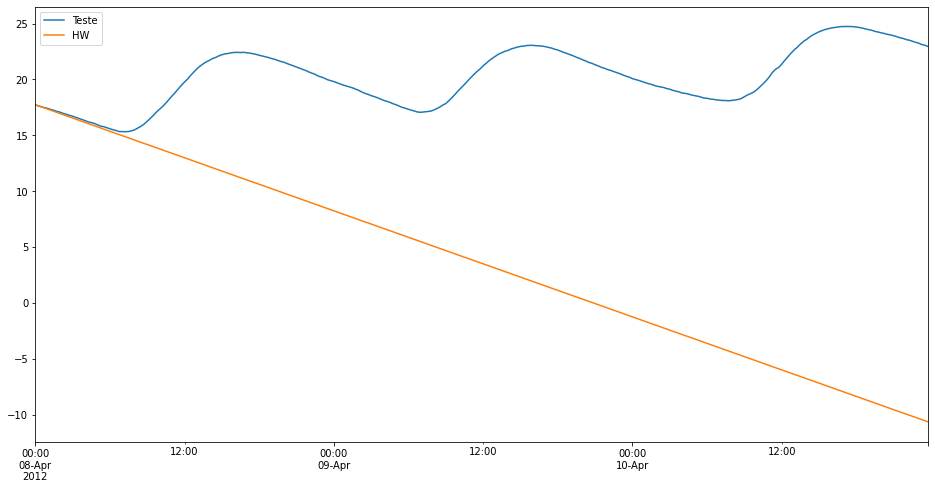

In [ ]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['HW'])

In [ ]:
#sarima
#Simular os melhores valores para os coeficientes (p,d,q)X(P,D,Q)M
stepwise_fit = auto_arima(dfTreino['Indoor_temperature_room'], start_p=3, start_q=3,
                          max_p=3, max_q=3, m=96,
                          seasonal=True,
                          trace=True,
                          error_action='ignore', # we don't want to know if an order does not work
                          suppress_warnings=True, # we don't want convergence warnings
                          stepwise=True) # set to stepwise
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,0,1)[96] intercept   : AIC=inf, Time=308.80 sec
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=-2575.225, Time=0.31 sec
 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=-7503.458, Time=167.89 sec
 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=inf, Time=103.83 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=-2577.165, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[96] intercept   : AIC=-7492.449, Time=0.17 sec


In [ ]:
# ajustando o melhor modelo indicado pelo stepwise e gerando o sumário.
modelo = SARIMAX(dfTreino['Indoor_temperature_room'],order=(0,1,0),seasonal_order=(0,0,0,96))
ajustado_sarimax = modelo.fit()
ajustado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     Indoor_temperature_room   No. Observations:                 2400
Model:                    SARIMAX(0, 1, 0)   Log Likelihood                1289.582
Date:                     Thu, 19 May 2022   AIC                          -2577.165
Time:                             23:58:12   BIC                          -2571.382
Sample:                         03-14-2012   HQIC                         -2575.061
                              - 04-07-2012                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0200      0.000     56.077      0.000       0.019       0.021
===================================================================================
Ljung-Box (L1) (Q):                2091.73   Jarque-Bera (JB):              1953.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#avaliando o modelo.
inicio=len(dfTreino)
fim=len(dfTreino)+len(dfTeste)-1
dfTeste['SARIMAX'] = ajustado_sarimax.predict(start=inicio, end=fim, dynamic=False, typ='levels')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
sarimax = mean_absolute_error(dfTeste['Indoor_temperature_room'],dfTeste['SARIMAX'])
print('MAE do SARIMAX:', sarimax)

MAE do SARIMAX: 2.878962152777777


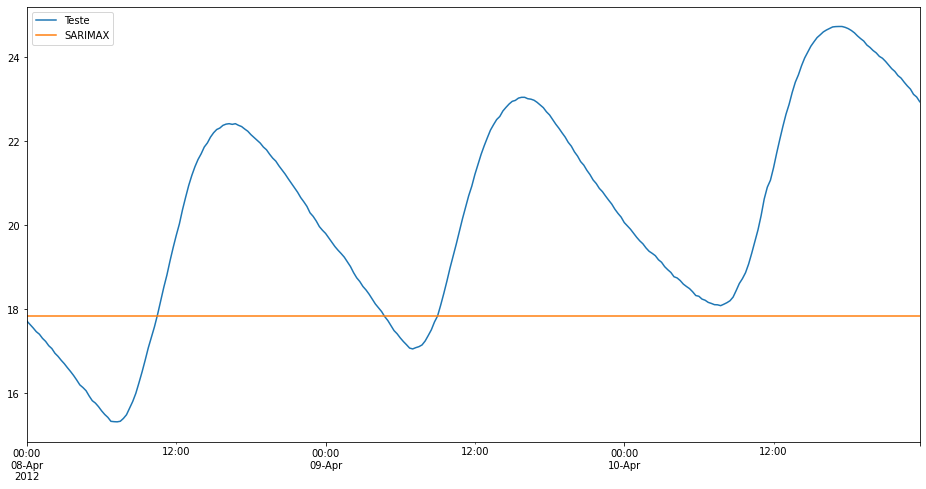

In [ ]:
plotaSeries(None, dfTeste['Indoor_temperature_room'], dfTeste['SARIMAX'])